In [1]:
# This notebook is for Section 4: Experimenta Analysis of the Twine Take Home Assignment
# Source Data: exp_results.csv

# import necessary modules

import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import ztest
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
results = pd.read_csv('exp_results.csv', sep=",", encoding='utf8')
results.head(10)

,userid,condition,age_group,goal_opened
0,914806,control,30-45,0
1,937075,message_1,46-55,0
2,286139,message_2,30-45,0
3,830447,control,30-45,0
4,641745,message_1,30-45,0
5,519095,message_2,30-45,0
6,736588,control,46-55,0
7,134666,message_1,30-45,0
8,656992,message_2,<30,0
9,705064,control,30-45,0


In [3]:
results.shape

(9954, 4)

In [4]:
results.info()

# seems that the data is clean. no missing values or incorrect data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9954 entries, 0 to 9953
Data columns (total 4 columns):
userid         9954 non-null int64
condition      9954 non-null object
age_group      9954 non-null object
goal_opened    9954 non-null int64
dtypes: int64(2), object(2)
memory usage: 311.1+ KB


In [5]:
results['condition'].unique()

array(['control', 'message_1', 'message_2'], dtype=object)

In [6]:
results['goal_opened'].unique()

array([0, 1])

In [7]:
results['age_group'].unique()

array(['30-45', '46-55', '<30', '55+'], dtype=object)

#### Question 1: Did either or both messages have a statistically significant effect? If so, how large were the effects?

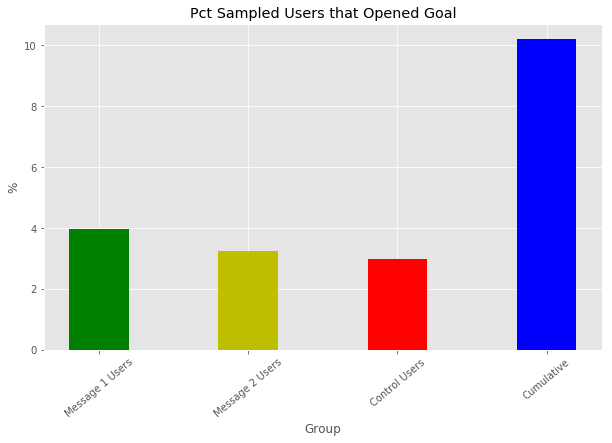

In [8]:
opened_all = results['goal_opened'].sum()
opened_msg1 = results['goal_opened'].loc[results['condition'] == 'message_1'].sum()
opened_msg2 = results['goal_opened'].loc[results['condition'] == 'message_2'].sum()
opened_ctrl = results['goal_opened'].loc[results['condition'] == 'control'].sum()

sample = results.shape[0]

plt.figure(figsize=(10,6))
plt.bar(
    ['Message 1 Users','Message 2 Users','Control Users', 'Cumulative'], 
    [(opened_msg1/sample)*100, (opened_msg2/sample)*100,(opened_ctrl/sample)*100, (opened_all/sample)*100],
    color=['g','y','r','b'], width=0.4)
plt.title('Pct Sampled Users that Opened Goal')
plt.ylabel('%')
plt.xlabel('Group')
plt.xticks(rotation=40)
plt.show()

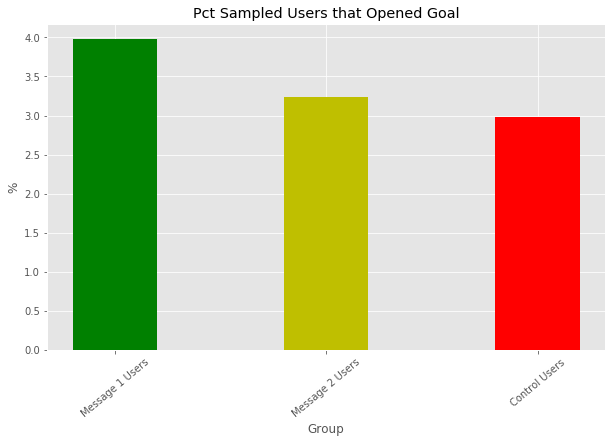

In [9]:
plt.figure(figsize=(10,6))

plt.bar(
    ['Message 1 Users','Message 2 Users','Control Users'], 
    [(opened_msg1/sample)*100, (opened_msg2/sample)*100,(opened_ctrl/sample)*100],
    color=['g','y','r','b'], width=0.4)
plt.title('Pct Sampled Users that Opened Goal')
plt.ylabel('%')
plt.xlabel('Group')
plt.xticks(rotation=40)
plt.show()

In [10]:
# detailed summary of the above plots

print('From the sample of {}, {} users opened a goal (or {:.2f}%).'.format(sample, opened_all, (opened_all/sample)*100))
print('From the sample of {}, {} users that received Message 1 opened a goal (or {:.2f}%).'.format(sample, opened_msg1, (opened_msg1/sample)*100))
print('From the sample of {}, {} users that received Message 2 opened a goal (or {:.2f}%).'.format(sample, opened_msg2, (opened_msg2/sample)*100))
print('From the sample of {}, {} users in the control opened a goal (or {:.2f}%).'.format(sample, opened_ctrl, (opened_ctrl/sample)*100))

From the sample of 9954, 1015 users opened a goal (or 10.20%).
From the sample of 9954, 396 users that received Message 1 opened a goal (or 3.98%).
From the sample of 9954, 322 users that received Message 2 opened a goal (or 3.23%).
From the sample of 9954, 297 users in the control opened a goal (or 2.98%).


At first glance, we see that users in the test group were more likely to open a goal compared to the control group.  We also see that users that received message 1 were more likely than users that received message 2 were more likely to open a goal.

However, to determine if this is statistically significant we must find the means of each cohort and perform further analysis

In [11]:
# get sample stats for each sub-sample
# I intend to compare the means of each user group, here we can consider the mean to be ratio of users in each group that
# opened a goal to the total users of each group. As the column 'opened_goal' is binary, we can sum up all the values
# of each group and arrive at a mean.
msg1_samp = results['userid'].loc[results['condition'] == 'message_1'].count()
msg1_mean = opened_msg1/msg1_samp

msg2_samp = results['userid'].loc[results['condition'] == 'message_2'].count()
msg2_mean = opened_msg2/msg2_samp

test_samp = results['userid'].loc[results['condition'] != 'control'].count() #get all users no part of the control
test_mean = (opened_msg1+opened_msg2)/test_samp

ctrl_samp = results['userid'].loc[results['condition'] == 'control'].count()
ctrl_mean = opened_ctrl/ctrl_samp

In [12]:
print('The message_1 group sample size is {} with a mean of {:.4f}.'.format(msg1_samp,msg1_mean))
print('The message_2 group sample size is {} with a mean of {:.4f}.'.format(msg2_samp,msg2_mean))

print('The TEST group sample size is {} with a mean of {:.4f}.'.format(test_samp,test_mean))
print('The CONTROL group sample size is {} with a mean of {:.4f}.'.format(ctrl_samp,ctrl_mean))

The message_1 group sample size is 3318 with a mean of 0.1193.
The message_2 group sample size is 3318 with a mean of 0.0970.
The TEST group sample size is 6636 with a mean of 0.1082.
The CONTROL group sample size is 3318 with a mean of 0.0895.


We will set up the following hypothesis tests:
1 - Test the message 1 mean vs. the control
2 - Test the message 2 mean vs. the control
3 - Test the TEST mean vs. the control

Methodology: Here we can apply the Central Limit Theorem as the sample sizes are large and that if we continually sample from each group, the resulting means will be normally distributed.  Hence, we will proceed using a z-test

In [13]:
# Test 1 - One-tailed z-test, with an alpha of 0.05 or confidence level of 0.95 (95%)

# H0: msg1_mean = ctrl_mean
# Ha: msg1_mean > ctrl_mean

# we reject the null in favor of the alternative if the z-stat is greater than z-score of 1.65

msg1_std = np.std(results['goal_opened'].loc[results['condition'] =='message_1'])

msg1_test_stat = (msg1_mean - ctrl_mean) / (msg1_std/np.sqrt(msg1_samp))

print(msg1_test_stat)

# Given that our test stat of 5.3 is greater than our z-stat of 1.65, we reject the null in favor of the alternative.
# let us repeat for msg2 and the entire test group to be thorough

5.301340344251082


In [14]:
# we repeat the one-tailed z-test with an alpha of 0.05/9% confidence level

# H0: msg2_mean = ctrl_mean
# HA: msg2_mean > ctrl_mean

msg2_std = np.std(results['goal_opened'].loc[results['condition'] == 'message_2'])

msg2_test_stat = (msg2_mean - ctrl_mean) / (msg2_std/np.sqrt(msg2_samp))

print(msg2_test_stat)

# Given that our msg2 test stat of 1.46 is LESS than our z-stat of 1.65, we fail to reject the null.
# It appears that only users that received Message_1 were more likely to open a goal at a statistically significant level

1.4661532221414573


In [15]:
# Repeat but for both messages

# H0: test_mean = ctrl_mean
# Ha: test_mean > ctrl_mean

test_std = np.std(results['goal_opened'].loc[results['condition'] != 'control'])

test_tstat = (test_mean - ctrl_mean) / (test_std/np.sqrt(test_samp))

print(test_tstat)

# Given that our test stat of 4.9 is greater than our z-stat is greater than 1.65, we reject the null in favor of the null.
# This suggests that users in the test group were statistically more likely to open a goal than the control group
# Coupled with the above tests, this is attributed to Message 1 than Message 2. 

4.900328238176529


#### Question 2: The marketing team suspects that message 2 might have had variable effects by age group. Did it show different effects in different age groups? If so, what were they?

In [16]:
# use group by function to visually inspect this
# age groups found earlier: array(['30-45', '46-55', '<30', '55+'], dtype=object)

# first convert age_group col to string dtype

results['agre_group'] = results['age_group'].astype('str')

In [17]:
results['goal_opened'].loc[results['condition'] == 'message_2'].groupby(results['age_group']).sum()


age_group
30-45    130
46-55     33
55+       26
<30      133
Name: goal_opened, dtype: int64

In [18]:
msg2_under_30 = results['goal_opened'].loc[results['condition'] == 'message_2'].groupby(results['age_group']).sum()[3]
msg2_30_to_45 = results['goal_opened'].loc[results['condition'] == 'message_2'].groupby(results['age_group']).sum()[0]
msg2_46_to_55 = results['goal_opened'].loc[results['condition'] == 'message_2'].groupby(results['age_group']).sum()[1]
msg2_55_up = results['goal_opened'].loc[results['condition'] == 'message_2'].groupby(results['age_group']).sum()[2]

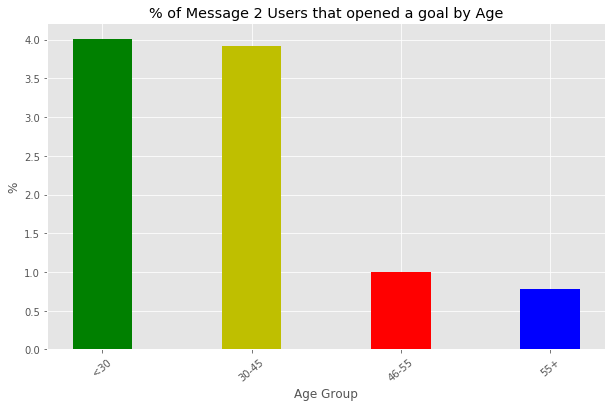

In [19]:

plt.figure(figsize=(10,6))
plt.bar(
    ['<30','30-45','46-55', '55+'], 
    [(msg2_under_30/msg2_samp)*100, (msg2_30_to_45/msg2_samp)*100,(msg2_46_to_55/msg2_samp)*100, (msg2_55_up/msg2_samp)*100],
    color=['g','y','r','b'], width=0.4)
plt.title('% of Message 2 Users that opened a goal by Age')
plt.ylabel('%')
plt.xlabel('Age Group')
plt.xticks(rotation=40)
plt.show()